In [188]:
Ind = ['2_2_1']
Indlabel=['$2_1^2$']

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [189]:
Nbeads = 500
time = 100
replicas = 32 #32

In [190]:
def determineLink(start, end, buffer=None):
    if buffer:
        end = (end + buffer) % Nbeads
        start = (start - buffer) % Nbeads
        
    if end < start:
        length = (Nbeads - start) + end
    else:
        length = end - start
            
    return start, end, length

In [191]:
def readLink(df, rep, buffer=None):

    starts_chain1=[]
    ends_chain1=[]
    starts_chain2=[]
    ends_chain2=[]
    lengths_chain1=[]
    lengths_chain2=[]

    # specific conformations to use
    if rep is not None:
        conf_start = rep*time
        conf_end = rep*time + time

    # use all conformations
    else:
        conf_start = 0
        conf_end = len(df)  

    for row in range(conf_start, conf_end):
        start, end, length = determineLink(df.iloc[row,3], df.iloc[row,4], buffer)
        starts_chain1.append(start)
        ends_chain1.append(end)
        lengths_chain1.append(length)
        start, end, length = determineLink(df.iloc[row,5], df.iloc[row,6], buffer)
        starts_chain2.append(start)
        ends_chain2.append(end)
        lengths_chain2.append(length)

    return starts_chain1, ends_chain1, starts_chain2, ends_chain2, lengths_chain1, lengths_chain2

In [192]:
## READING MAX DENSITY OR WRITHE FILE AND CORRESPONDING BEAD INDEX
def readDescriptor(file, index=3):
    print(file)
    g=open(file,"r")
    lines = g.readlines()[1:] #skip header
    maxval_chain1=[]
    maxval_chain2=[]
    
    for x in lines:
        if int(x.split(' ')[1]) == 0:
            maxval_chain1.append(int(x.split(' ')[index]))

        else:
            maxval_chain2.append(int(x.split(' ')[index]))
    g.close()
    
    return maxval_chain1, maxval_chain2

In [193]:
def colocalise(start_list1, end_list1, maxval_list1, start_list2, end_list2, maxval_list2):
    ## CALCULATING COLOCALISATION FREQUENCY OF MAXMIAL GEOMETRIC DESCIPTOR WITH LINKED SEGMENT FOR BOTH CHAINS
    prob1 = 0
    prob2 =  0
    totalprob_real = 0
    #ring is circular, need to take into account both ends
    for j in range(time):
        within1 = False
        within2 = False
        k = (j*skip) + start_time
        if (start_list1[j]>end_list1[j]):
            if ((maxval_list1[k]>=start_list1[j]) or (maxval_list1[k]<=end_list1[j])):
                prob1+=1
                within1 = True
            else: 
                within1 = False
        elif (start_list1[j]<end_list1[j]):
            if ((maxval_list1[k]>start_list1[j]) and (maxval_list1[k]<end_list1[j])):
                prob1+=1
                within1 = True
            else:
                within1 = False
        if (start_list2[j]>end_list2[j]):
            if ((maxval_list2[k]>=start_list2[j]) or (maxval_list2[k]<=end_list2[j])):
                prob2+=1
                within2 = True
            else: 
                within2 = False
        elif (start_list2[j]<end_list2[j]):
            if ((maxval_list2[k]>start_list2[j]) and (maxval_list2[k]<end_list2[j])):
                prob2+=1
                within2 = True
            else:
                within2 = False

        if within1 and within2:
            totalprob_real += 1
    prob1 /= time
    prob2 /= time
    totalprob_real /= time
    
    totalprob_multiply = prob1 * prob2

    print(prob1, prob2, totalprob_real, totalprob_multiply)
    
    return prob1, prob2, totalprob_real, totalprob_multiply

In [194]:
def random_calc(rep=None, filepath = "KNOT2_2_1\LinkedPortionFirst100.dat", buffer=None):

    df = pd.read_table(filepath, sep='\s+', header=None)  

    _, _, _, _, lengths_chain1, lengths_chain2 = readLink(df, rep, buffer)

    averagelength_chain1 = np.mean(lengths_chain1)
    averagelength_chain2 = np.mean(lengths_chain2)
    average_total_length = averagelength_chain1 + averagelength_chain2

    randomprob_chain1 = averagelength_chain1/Nbeads
    randomprob_chain2 = averagelength_chain2/Nbeads
    total_randomprob_real = average_total_length/(Nbeads*2)
    total_randomprob = randomprob_chain1 * randomprob_chain2
     
    print(randomprob_chain1, randomprob_chain2, total_randomprob, total_randomprob_real)
    return randomprob_chain1, randomprob_chain2, total_randomprob

In [195]:
def max_correlation(filepath2, name, rep=None, filepath1 = "KNOT2_2_1\LinkedPortionFirst100.dat", index=3, buffer=None, score=False, random=False):

    ## READING LINKING FILE TO CALCULATE LENGTH AND START AND END OF LINKED SEGMENT
    df = pd.read_table(filepath1, sep='\s+', header=None)     

    starts_chain1, ends_chain1, starts_chain2, ends_chain2, _, _ = readLink(df, rep, buffer)
    
    maxval_chain1, maxval_chain2 = readDescriptor(filepath2, index)
    
    prob_chain1, prob_chain2, total_prob, total_prob_multiply = colocalise(starts_chain1, ends_chain1, maxval_chain1, starts_chain2, ends_chain2, maxval_chain2)

    if score:
        randomprob_chain1, randomprob_chain2, total_randomprob = random_calc(rep, filepath1)
        datascore.append([Indlabel[0], rep, prob_chain1/(randomprob_chain1), "Chain 1", name])
        datascore.append([Indlabel[0], rep, prob_chain2/(randomprob_chain2), "Chain 2", name])
        datascore.append([Indlabel[0], rep, total_prob/(total_randomprob), "Link", name])

    elif random:
        randomprob_chain1, randomprob_chain2, total_randomprob = random_calc(rep, filepath1)
        data.append([Indlabel[0], rep, randomprob_chain1, "Chain 1", "Random Probability"])
        data.append([Indlabel[0], rep, randomprob_chain2, "Chain 2", "Random Probability"])
        data.append([Indlabel[0], rep, total_randomprob, "Link", "Random Probability"])    
    
    else:
        data.append([Indlabel[0], rep, prob_chain1, "Chain 1", name])
        data.append([Indlabel[0], rep, prob_chain2, "Chain 2", name])
        data.append([Indlabel[0], rep, total_prob, "Link", name])

    return

In [196]:
def plot(df, title, y="Colocalisation Fraction", num_labels=3, score=False):
    #set figure details
    sns.set_theme(style="ticks", palette="colorblind", font_scale=2)
    st = sns.axes_style("whitegrid")
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.figure(figsize=(8,8))

    #swarmplot
    sns.swarmplot(x="Component", y=y, hue="Representation", data=df, size=4, dodge=True)

    ax1 = sns.boxplot(x="Component", y=y,hue="Representation",data=df, linewidth=2.5, showfliers=False)

    if not score:
        ax1.set(ylim=(0,1))

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles[0:], labels=labels[0:num_labels])
    plt.savefig(title)
    # plt.savefig("ColocalisationFractionLinktest_REFACTORED.pdf")
    return

In [ ]:
# main for 32 first 100
start_time = 0
skip = 1
data = []
datascore = []
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Global", rep)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Global", rep)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Global ", rep, score=True)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Global", rep, score=True)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Diff", rep, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Diff", rep, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Diff", rep, score=True, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Diff", rep, score=True, index=5)

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Knot Type', 'Replica #', 'Colocalisation Fraction', 'Component', 'Representation'])
dfscore = pd.DataFrame(datascore, columns = ['Knot Type', 'Replica #', 'Colocalisation Score', 'Component', 'Representation'])

df.to_csv("KnotColocalisationFraction32FIRST.csv")
dfscore.to_csv("KnotColocalisationScore32FIRST.csv")

D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.42 0.57 0.22 0.23939999999999997
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.42 0.57 0.22 0.23939999999999997
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.61 0.79 0.52 0.4819
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.42 0.57 0.22 0.23939999999999997
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.61 0.79 0.52 0.4819
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.94 0.66 0.6579999999999999
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.89 1.0 0.89 0.89
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.94 0.66 0.6579999999999999
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.

c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


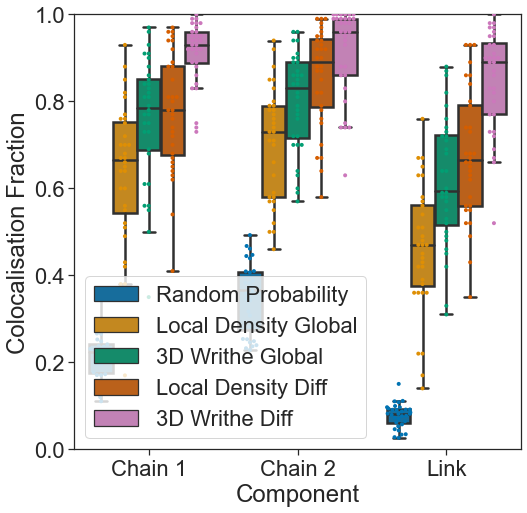

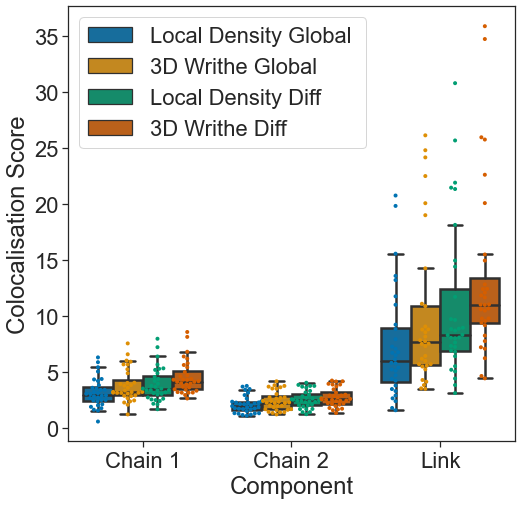

In [163]:
plot(df, "ColocalisationFractionLink32FIRST.pdf", num_labels=5)
plot(dfscore, "ColocalisationScoreLink32FIRST.pdf", "Colocalisation Score", num_labels=4, score=True)

In [175]:
# main for 32 last

start_time = 900
skip = 1
data = []
datascore = []
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Global", rep, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Global", rep, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Global ", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Global", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Diff", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Diff", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density Diff", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe Diff", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Knot Type', 'Replica #', 'Colocalisation Fraction', 'Component', 'Representation'])
dfscore = pd.DataFrame(datascore, columns = ['Knot Type', 'Replica #', 'Colocalisation Score', 'Component', 'Representation'])

df.to_csv("KnotColocalisationFraction32LAST.csv")
dfscore.to_csv("KnotColocalisationScore32LAST.csv")

D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.66 0.09 0.07 0.0594
0.040100000000000004 0.08586 0.0034429860000000007 0.06298000000000001
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.66 0.09 0.07 0.0594
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.84 0.61 0.55 0.5124
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.66 0.09 0.07 0.0594
0.040100000000000004 0.08586 0.0034429860000000007 0.06298000000000001
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.84 0.61 0.55 0.5124
0.040100000000000004 0.08586 0.0034429860000000007 0.06298000000000001
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.74 0.67 0.51 0.4958
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.88 0.77 0.71 0.6776
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.74 0.67 0.51 0.4958
0.040100000000000004 0.08586 0.0034429860000000007 0.06298000000000001
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.88 0.77 0.71 0.6776
0.040100000000000004

c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.4% of the points

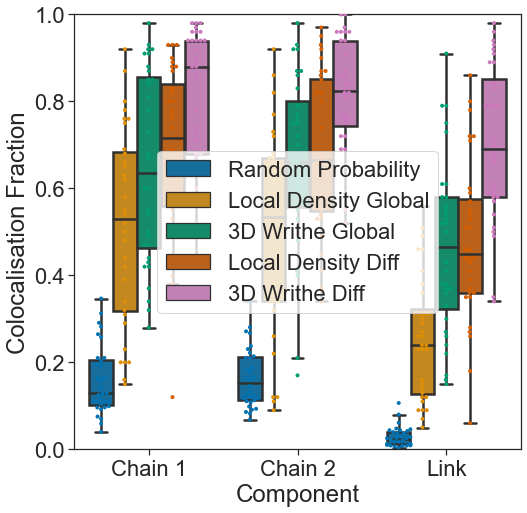

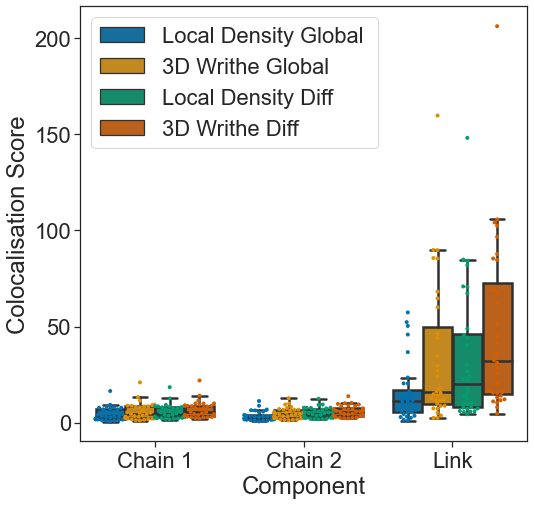

In [176]:
plot(df, "ColocalisationFractionLink32LAST.pdf", num_labels=5)
plot(dfscore, "ColocalisationScoreLink32LAST.pdf", "Colocalisation Score", num_labels=4, score=True)

In [201]:
# main for 32 every 10th

start_time=0
skip = 10
data = []
datascore = []
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density ", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Knot Type', 'Replica #', 'Colocalisation Fraction', 'Component', 'Representation'])
dfscore = pd.DataFrame(datascore, columns = ['Knot Type', 'Replica #', 'Colocalisation Score', 'Component', 'Representation'])

df.to_csv("KnotColocalisationFraction32EVERY10DIFF.csv")
dfscore.to_csv("KnotColocalisationScore32EVERY10DIFF.csv")

D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.54 0.5 0.27 0.27
0.1335 0.19186 0.02561331 0.16268000000000002
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.82 0.61 0.574
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.88 0.9 0.82 0.792
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.82 0.61 0.574
0.1335 0.19186 0.02561331 0.16268000000000002
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.88 0.9 0.82 0.792
0.1335 0.19186 0.02561331 0.16268000000000002
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.79 0.55 0.47 0.43450000000000005
0.1147 0.19074000000000002 0.021877878000000003 0.15272
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.92 0.87 0.8 0.8004
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_11.lp20.dat
0.93 0.97 0.9 0.9021
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.92 0.87 0.8 0.8004
0.1147 0.19074000000000002 0.021877878000000003 0.15272
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_11.lp20.dat
0

c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


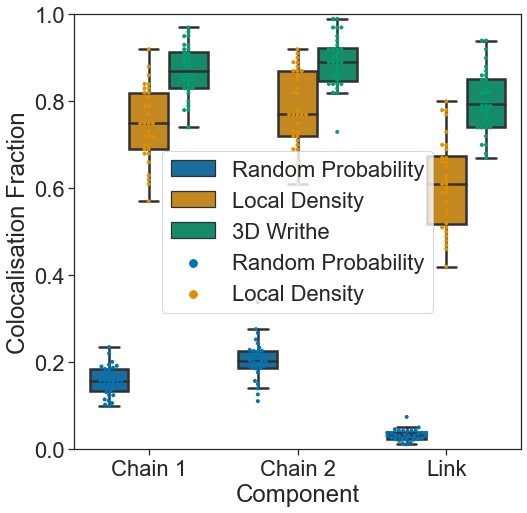

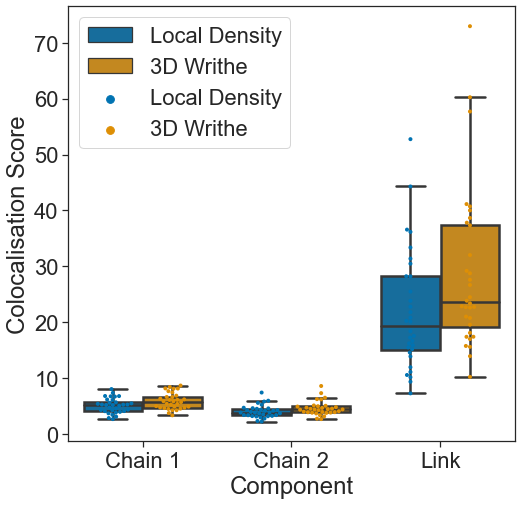

In [202]:
plot(df, "ColocalisationFractionLink32EVERY10DIFF.pdf", num_labels=5)
plot(dfscore, "ColocalisationScoreLink32EVERY10DIFF.pdf", "Colocalisation Score", num_labels=4, score=True)

In [205]:
# main for ALL data
data = []
datascore = []

#first 100
start_time = 0
skip = 1
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True)
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep)
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep)
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density ", rep, score=True)
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, score=True, index=5)
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, index=5)

#last 100
start_time = 900
skip = 1
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density ", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionLast100.dat")

#every 10th
start_time=0
skip = 10
for i in range(len(Ind)):
    for rep in range(replicas):
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Random", rep, random=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density ", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        # max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\LDMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".rad20.dat", "Local Density", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")
        max_correlation("D:\Hopf\KNOT"+str(Ind[i])+"\WritheMAX_PLUSDIFF_KNOT"+str(Ind[i])+str(rep) + ".lp20.dat", "3D Writhe", rep, score=True, index=5, filepath1 = "KNOT2_2_1\LinkedPortionEvery10.dat")

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Knot Type', 'Replica #', 'Colocalisation Fraction', 'Component', 'Representation'])
dfscore = pd.DataFrame(datascore, columns = ['Knot Type', 'Replica #', 'Colocalisation Score', 'Component', 'Representation'])

df.to_csv("KnotColocalisationFraction32ALLDIFF.csv")
dfscore.to_csv("KnotColocalisationScore32ALLDIFF.csv")

D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.42 0.57 0.22 0.23939999999999997
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.94 0.66 0.6579999999999999
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.89 1.0 0.89 0.89
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_10.rad20.dat
0.7 0.94 0.66 0.6579999999999999
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_10.lp20.dat
0.89 1.0 0.89 0.89
0.26530000000000004 0.34238 0.09083341400000002 0.30384000000000005
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.85 0.75 0.65 0.6375
0.24830000000000002 0.36898000000000003 0.09161773400000002 0.30863999999999997
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.88 0.92 0.8 0.8096
D:\Hopf\KNOT2_2_1\WritheMAX_PLUSDIFF_KNOT2_2_11.lp20.dat
0.99 0.99 0.98 0.9801
D:\Hopf\KNOT2_2_1\LDMAX_PLUSDIFF_KNOT2_2_11.rad20.dat
0.88 0.92 0.8 0.8

c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 52.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\josep\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.9% of the points

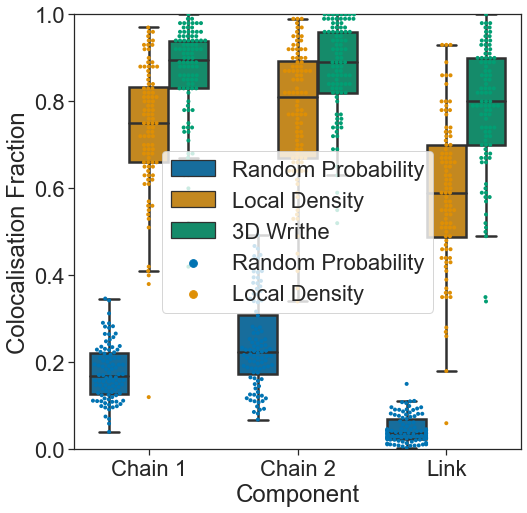

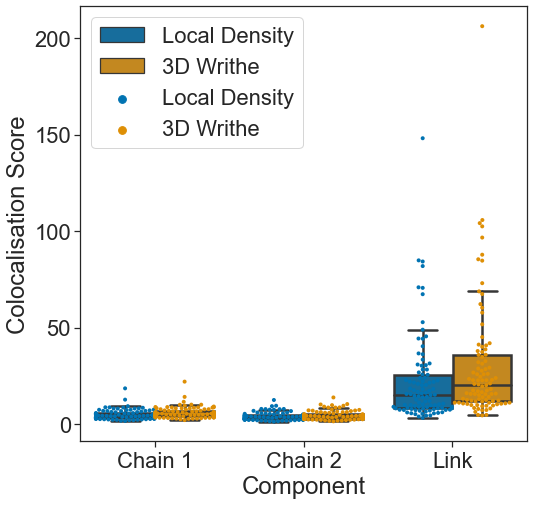

In [206]:
plot(df, "ColocalisationFractionLink32ALLDIFF.pdf", num_labels=5)
plot(dfscore, "ColocalisationScoreLink32ALLDIFF.pdf", "Colocalisation Score", num_labels=4, score=True)